MSE Polynomial (degree 2): 0.2809144539110226
MSE Polynomial (degree 3): 0.19009212654759094
MSE Polynomial (degree 4): 0.1641365990699455
MSE Gaussian (degree 2, s=1.0): 0.3419411333946863
MSE Gaussian (degree 5, s=1.0): 6.209003209230033
MSE Gaussian (degree 5, s=0.5): 0.20541906644161667
MSE Sigmoidal (degree 2, s=1.0): 0.2472529163706629
MSE Sigmoidal (degree 5, s=1.0): 0.543504839043394
MSE Sigmoidal (degree 5, s=0.5): 0.1743223382887257


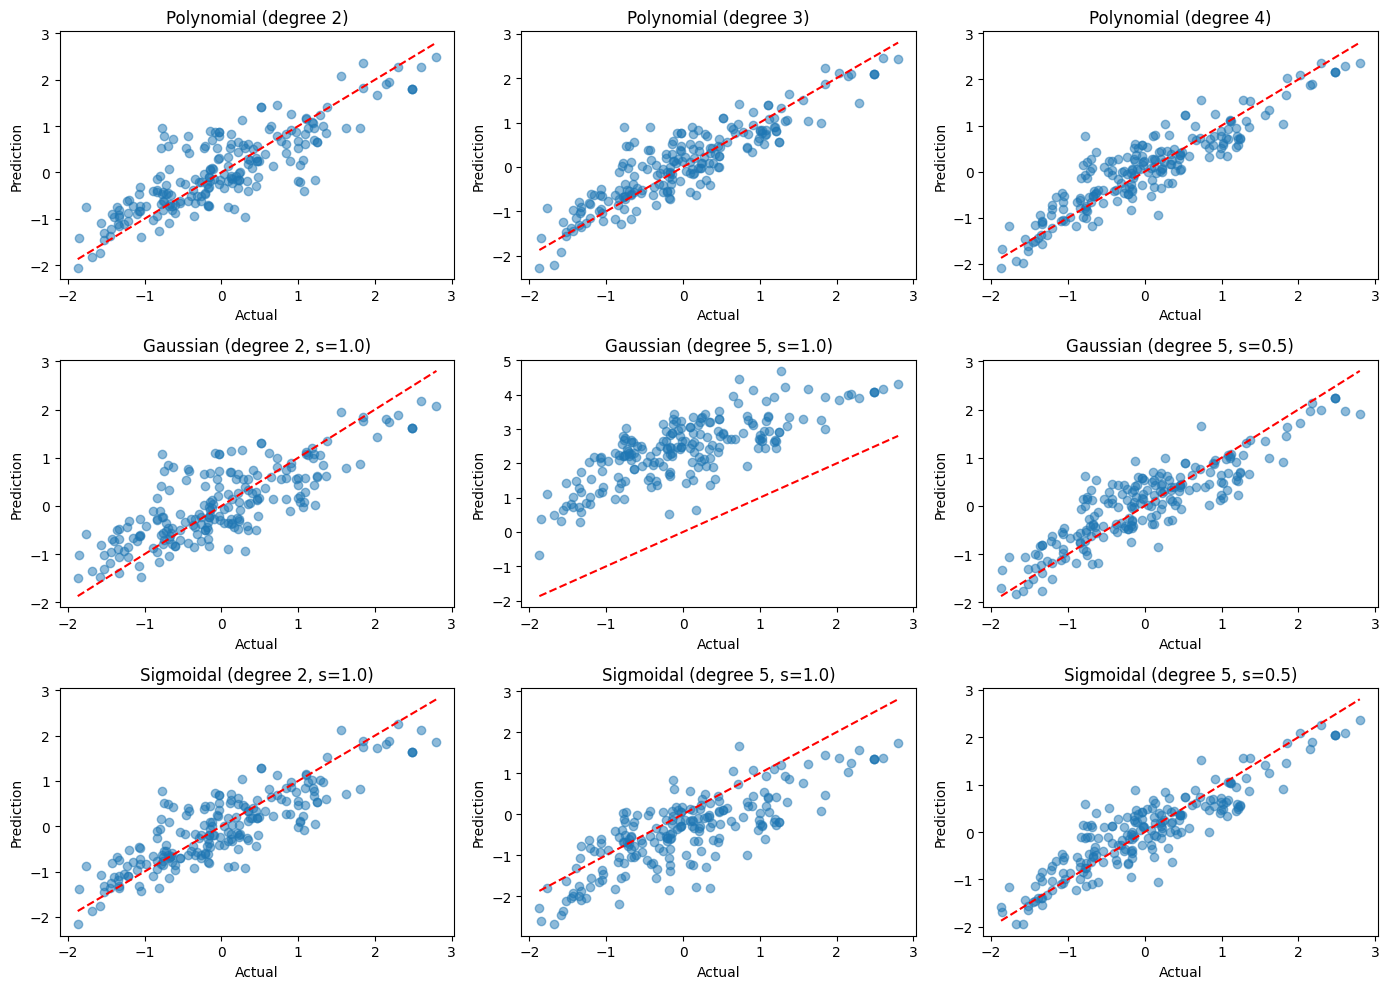

In [24]:
# Doeger Orcun Ilker

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_excel("Concrete_Data.xls")

dataNormalized = (data - data.mean()) / data.std()

# Shuffle the columns randomly (as they were )
dataRandom = dataNormalized.sample(frac=1, axis=0, random_state=45)

# Split Training, Test
trainSize = int(0.8 * len(dataRandom))
trainData = dataRandom[:trainSize]
testData = dataRandom[trainSize:]

# Drop/Keeponly the last column (Target)
XTrain = trainData.iloc[:, :-1].values
yTrain = trainData.iloc[:, -1].values
XTest = testData.iloc[:, :-1].values
yTest = testData.iloc[:, -1].values



class LinearBasisFunctionModels:
    def __init__(model, basisFunction, degree=None, s=1.0):
        model.coefficients = None
        
        model.basisFunction = basisFunction
        model.degree = degree
        model.s = s


    def fit(model, XTrain, y):
        Phi = model.computeBasisFunctions(XTrain)
        
        onesColumn = np.ones(Phi.shape[0]) 
        Phi = np.c_[onesColumn, Phi] # add Intercept
        
        model.coefficients = np.dot(np.linalg.inv(np.dot(Phi.T, Phi)), np.dot(Phi.T, y)) # Minimizing Error of Least Squares

    def predict(model, XTest):
        Phi = model.computeBasisFunctions(XTest)
        
        onesColumn = np.ones(Phi.shape[0]) 
        Phi = np.c_[onesColumn, Phi] # add Intercept
        
        return np.dot(Phi, model.coefficients)


    def computeBasisFunctions(model, X):
        if model.basisFunction == 'polynomial':
            return model.polynomialBasisFunctions(X)
        elif model.basisFunction == 'gaussian':
            return model.gaussianBasisFunctions(X)
        elif model.basisFunction == 'sigmoidal':
            return model.sigmoidalBasisFunctions(X)
        else:
            return None

    def polynomialBasisFunctions(model, X):
        features = [X] # original values
        for i in range(2, model.degree + 1):
            features.append(X ** i) # add the polynomial to the original values
        Phi = np.hstack(features)
        return Phi

    def gaussianBasisFunctions(model, X):
        evenlySpacedMeans = np.linspace(np.min(X, axis=0), np.max(X, axis=0), model.degree)
        features = []
        for mu in evenlySpacedMeans:
            features.append(np.exp(-(X - mu) ** 2 / (2 * model.s ** 2))) # gaussain basis function
        Phi = np.hstack(features)
        return Phi

    def sigmoidalBasisFunctions(model, X):
        evenlySpacedMeans = np.linspace(np.min(X, axis=0), np.max(X, axis=0), model.degree)
        features = []
        for mu in evenlySpacedMeans:
            features.append(1 / (1 + np.exp(-(X - mu) / model.s))) # sigmoidal basis function
        Phi = np.hstack(features)
        return Phi




# Initializing Models
models = {
    "Polynomial (degree 2)": LinearBasisFunctionModels(basisFunction='polynomial', degree=2),
    "Polynomial (degree 3)": LinearBasisFunctionModels(basisFunction='polynomial', degree=3),
    "Polynomial (degree 4)": LinearBasisFunctionModels(basisFunction='polynomial', degree=4),
    "Gaussian (degree 2, s=1.0)": LinearBasisFunctionModels(basisFunction='gaussian', degree=2, s=1.0),
    "Gaussian (degree 5, s=1.0)": LinearBasisFunctionModels(basisFunction='gaussian', degree=5, s=1.0),
    "Gaussian (degree 5, s=0.5)": LinearBasisFunctionModels(basisFunction='gaussian', degree=5, s=0.5),
    "Sigmoidal (degree 2, s=1.0)": LinearBasisFunctionModels(basisFunction='sigmoidal', degree=2, s=1.0),
    "Sigmoidal (degree 5, s=1.0)": LinearBasisFunctionModels(basisFunction='sigmoidal', degree=5, s=1.0),
    "Sigmoidal (degree 5, s=0.5)": LinearBasisFunctionModels(basisFunction='sigmoidal', degree=5, s=0.5)
}
predictions = {}
mses = {}

# Fit each Model and calculate MSEs
for modelName in models:
    model = models[modelName]
    model.fit(XTrain, yTrain)
    
    yPred = model.predict(XTest)
    predictions[modelName] = yPred
    
    squaredErrors = (yPred - yTest) ** 2
    mse = np.mean(squaredErrors)
    mses[modelName] = mse
    
    print("MSE {}: {}".format(modelName, mse))



# Plot the results for accuracy
plt.figure(figsize=(14, 10))
i = 1 # for subplots
for modelName in predictions:
    yPred = predictions[modelName]
    plt.subplot(3, 3, i)
    plt.scatter(yTest, yPred, alpha=0.5)
    plt.plot([min(yTest), max(yTest)], [min(yTest), max(yTest)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.title(modelName)
    i += 1

plt.tight_layout()
plt.show()


# Discussion

## 1. Data
The dataset "Concrete Compressive Strength" from the UCI Database has been used. 8 Features + 1 Target is given with 1030 instances. <br>
Objective: Predict "Concrete compressive strength in megapascal" out of the 8 features (kg of cement, kg of water.. /m3; age in days) <br>

## 2. Implementation of linear regression
After the data has been normalized and split into train and test set (0.8/0.2), it is fitted to 3 different Basis Functions:

#### 1. Polynomial Basis Functions:
By introducing polynoamial terms, we are able to make a non-linear relationship between features and target. For each feature, we compute a polynomial (of a specific degree) and stack it onto the original features.

#### 2. Gaussain Basis Functions:
We create (degree-)times evenly spaced Means, which we make Gaussain distributions of by this formula: <br>
![Gaussain](images/gaussain.png "Gaussan")

#### 3. Sigmoidal Basis Functions:
Similar to Gaussain, we create (degree-)times evenly spaced Means, which we make sigmoidal distributions of by this formula: <br>
![Sigmoidal](images/sigmoidal.png "Sigmoidal")

<br>
After the basis function have been created, we apply them (fit) to the Least Squares method: <br>

![LeastSquares](images/leastsquare.png "LeastSquares")

As we have the coefficients to predict new data now, we can apply the coefficients of the Training data to the Test data to predict the Concrete Strength.


## 3. Evaluation
#### Polynomial:
Polynomial Terms are espacially good for complex patterns in data. As this might be not necessarily the case here, it doesn't perform a lot better then the other two methods.
As we can see in the plots, we get a quite OK estimation of the Values. Increasing the degree of the polynomials increases the quality of the predictions even further.

#### Gaussain:
Not quite as good as the polynomial BFs, we still get good predicitons. In this case, we can see that reducing the spread increases the prediciton quality. Where the Gaussain falls apart here, is when the degree AND spread is high.

#### Sigmoidal:
As sigmoidal bfs perform especially good for more extreme values, it doesn't outperform the other methods either.
Decreasing the spread had a good effect here also.